In [ ]:
!pip install mplfinance


In [ ]:
import mplfinance as fplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import OneHotEncoder

In [ ]:
RANDOM = 0

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/EURUSD_M1_200001030001_202309012358.csv', sep = '\t')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8614601 entries, 0 to 8614600
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   <DATE>     object 
 1   <TIME>     object 
 2   <OPEN>     float64
 3   <HIGH>     float64
 4   <LOW>      float64
 5   <CLOSE>    float64
 6   <TICKVOL>  int64  
 7   <VOL>      int64  
 8   <SPREAD>   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 591.5+ MB


In [ ]:
data.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2000.01.03,00:01:00,1.0073,1.0075,1.0073,1.0073,5,0,50
1,2000.01.03,00:02:00,1.0079,1.0079,1.0079,1.0079,1,0,50
2,2000.01.03,00:04:00,1.0078,1.0080,1.0077,1.0080,4,0,50
3,2000.01.03,00:12:00,1.0079,1.0079,1.0079,1.0079,1,0,50
4,2000.01.03,00:13:00,1.0080,1.0080,1.0077,1.0077,4,0,50


In [ ]:
DIGITS = 10**4

In [ ]:
for i in range(len(data.columns)):
    strng = data.columns[i]
    data = data.rename({strng: ''.join(e for e in strng.lower() if e.isalnum())}, axis=1)

In [ ]:
data['datetime'] = pd.to_datetime(data['date'] + " " + data['time'], format='%Y.%m.%d %H:%M:%S')

In [ ]:
data = data.drop(['date', 'time', 'vol'], axis=1)

In [ ]:
data = data.set_index('datetime')

In [ ]:
data = data.rename({'tickvol': 'volume'}, axis=1)

In [ ]:
data.head()

,open,high,low,close,volume,spread
datetime,,,,,,
2000-01-03 00:01:00,1.0073,1.0075,1.0073,1.0073,5,50
2000-01-03 00:02:00,1.0079,1.0079,1.0079,1.0079,1,50
2000-01-03 00:04:00,1.0078,1.0080,1.0077,1.0080,4,50
2000-01-03 00:12:00,1.0079,1.0079,1.0079,1.0079,1,50
2000-01-03 00:13:00,1.0080,1.0080,1.0077,1.0077,4,50


In [ ]:
aggregation = {'open'  :'first',
               'high'  :'max',
               'low'   :'min',
               'close' :'last',
               'volume':'sum',
               'spread':'max'}

Text(0.5, 1.0, 'M1')

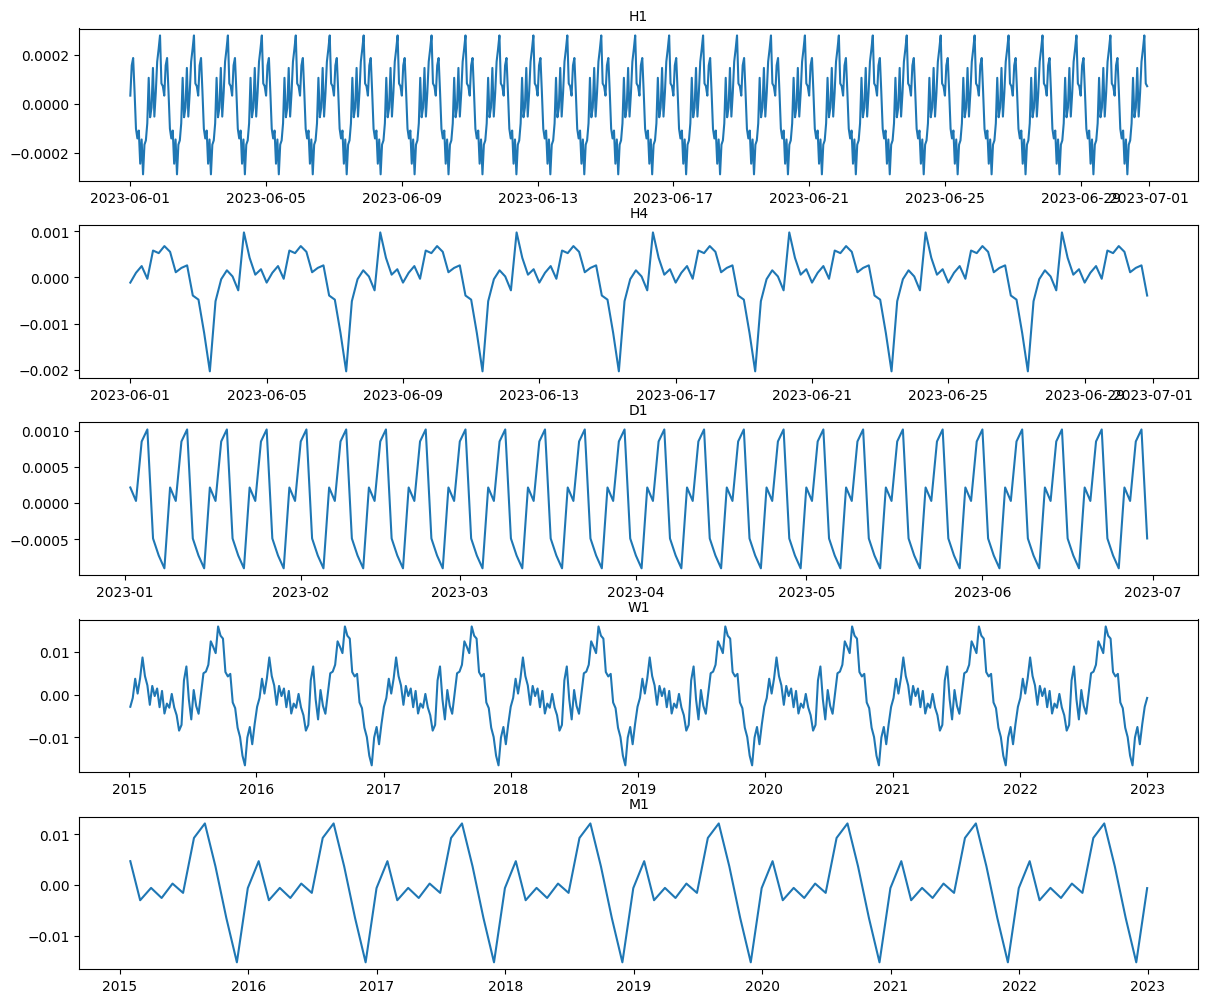

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(12,10))

fig.tight_layout()

temp = data['2023-06-01':'2023-06-30'].resample('1H').agg(aggregation)
result = seasonal_decompose(temp.close.fillna(method='ffill').dropna())
ax[0].plot(result.seasonal.index, result.seasonal)
ax[0].set_title('H1', fontsize=10)

temp = data['2023-06-01':'2023-06-30'].resample('4H').agg(aggregation)
result = seasonal_decompose(temp.close.fillna(method='ffill').dropna())
ax[1].plot(result.seasonal.index, result.seasonal)
ax[1].set_title('H4', fontsize=10)

temp = data['2023-01-01':'2023-06-30'].resample('1D').agg(aggregation)
result = seasonal_decompose(temp.close.fillna(method='ffill').dropna())
ax[2].plot(result.seasonal.index, result.seasonal)
ax[2].set_title('D1', fontsize=10)

temp = data['2015-01-01':'2023-01-01'].resample('1W').agg(aggregation)
result = seasonal_decompose(temp.close.fillna(method='ffill').dropna())
ax[3].plot(result.seasonal.index, result.seasonal)
ax[3].set_title('W1', fontsize=10)

temp = data['2015-01-01':'2023-01-01'].resample('1M').agg(aggregation)
result = seasonal_decompose(temp.close.fillna(method='ffill').dropna())
ax[4].plot(result.seasonal.index, result.seasonal)
ax[4].set_title('M1', fontsize=10)

In [ ]:
data_h4[data_h4.isna()]

,open,high,low,close,volume,spread,close_d,target,gap,volaty
datetime,,,,,,,,,,
2000-01-03 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_h4= data.resample('4H').agg(aggregation).fillna(method='ffill')

In [ ]:
data=[]

In [ ]:
data_h4['close_d']=data_h4['close'].diff()

In [ ]:
#print("%.3f" % adfuller(data_h4.close_d.dropna())[1])

In [ ]:
data_h4['target'] = data_h4['close'].shift(-5)

In [ ]:
#data_h4['gap'] = abs(data_h4.open-data_h4.close.shift(1))*DIGITS
#data_h4['volaty'] = (data_h4.high-data_h4.low)*DIGITS

In [ ]:
data_h4.head(10)

,open,high,low,close,volume,spread,close_d,target
datetime,,,,,,,,
2000-01-03 00:00:00,1.0073,1.0190,1.0073,1.0175,670,50.0,NaN,1.0246
2000-01-03 04:00:00,1.0173,1.0181,1.0154,1.0157,609,50.0,-0.0018,1.0241
2000-01-03 08:00:00,1.0154,1.0167,1.0093,1.0115,1731,50.0,-0.0042,1.0241
2000-01-03 12:00:00,1.0118,1.0118,1.0054,1.0073,1562,50.0,-0.0042,1.0276
2000-01-03 16:00:00,1.0077,1.0240,1.0070,1.0218,1484,50.0,0.0145,1.0326
2000-01-03 20:00:00,1.0218,1.0278,1.0213,1.0246,586,50.0,0.0028,1.0281
2000-01-04 00:00:00,1.0243,1.0266,1.0233,1.0241,836,50.0,-0.0005,1.0292
2000-01-04 04:00:00,1.0239,1.0266,1.0227,1.0241,1049,50.0,0.0000,1.0292
2000-01-04 08:00:00,1.0234,1.0279,1.0213,1.0276,1657,50.0,0.0035,1.0317


In [ ]:
data_h4 = data_h4.dropna()

data_h4.shape

(51852, 8)

In [ ]:
#data_h4 = data_h4.tail(1000)

In [ ]:
tscv = TimeSeriesSplit(n_splits=50, test_size=100)

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

In [ ]:
results = []

In [ ]:
def make_features_dow(data, _, __):
    name = 'dayofweek'
    feature = np.array(data.index.dayofweek).reshape(-1, 1)
    ohe = OneHotEncoder().fit(feature)
    ohe_data = pd.DataFrame(ohe.transform(feature).toarray(), columns=ohe.get_feature_names_out(['day_of_week']), index=data.index)
    dt = pd.concat([data, ohe_data], axis=1)
    return dt, name

def make_features_doy(data, _, __):
    dt = data.copy()
    name = 'dayofyear'
    dt['dayofyear'] = dt.index.dayofyear
    return dt, name

def make_features_month(data, _, __):
    name = 'month'
    feature = np.array(data.index.month).reshape(-1, 1)
    ohe = OneHotEncoder().fit(feature)
    ohe_data = pd.DataFrame(ohe.transform(feature).toarray(), columns=ohe.get_feature_names_out(['month']), index=data.index)
    dt = pd.concat([data, ohe_data], axis=1)
    return dt, name

def make_features_lag(data, col, max_lag):
    dt = data.copy()
    name = 'lag_{}'.format(max_lag)
    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt[col].shift(lag)
    return dt, name

def make_features_sma(data, col, rolling_mean_size):
    dt = data.copy()
    name = 'rolling_mean_{}'.format(rolling_mean_size)
    dt['rolling_mean'] = dt[col].shift().rolling(rolling_mean_size).mean()
    return dt, name

def make_features_sma(data, col, rolling_mean_size):
    dt = data.copy()
    name = 'rolling_mean_{}'.format(rolling_mean_size)
    dt['rolling_mean'] = dt[col].shift().rolling(rolling_mean_size).mean()
    return dt, name

def ema(data, rolling_mean_size):
    dt = data.shift().ewm(span=rolling_mean_size).mean()
    return dt

def make_features_macd(data, col, rolling_mean_size):
    name = 'macd'
    dt = data.copy()
    dt['macd'] = ema(dt[col], rolling_mean_size[0])-ema(dt[col], rolling_mean_size[1])
    return dt, name

def make_features_rsi(data, col, rolling_mean_size):
    dt = data.copy()
    name = 'rsi'
    udt = dt[col]-dt[col].shift()
    udt = udt[udt>0]
    ddt = dt[col].shift()-dt[col]
    ddt = ddt[ddt>0]
    rs = ema(udt, rolling_mean_size)/ema(ddt, rolling_mean_size)
    dt['rsi'] = 1-1/(1+rs)
    return dt, name

def make_features_stochastic(data, col, rolling_size):
    name = 'stochastic'
    dt = data.copy()
    dt['macd'] = ((data.close-dt['low'].shift().rolling(rolling_size).min())/
                (dt['high'].shift().rolling(rolling_size).max()-dt['low'].shift().rolling(rolling_size).min()))
    return dt, name

In [ ]:
make_features = []
make_features.append([make_features_dow, 0, 0])
make_features.append([make_features_doy, 0, 0])
make_features.append([make_features_month, 0, 0])
make_features.append([make_features_lag, 'close', 6])
make_features.append([make_features_lag, 'close', 6*5])
make_features.append([make_features_sma, 'close', 6])
make_features.append([make_features_sma, 'close', 6*5])
make_features.append([make_features_sma, 'close', 6*22])
make_features.append([make_features_macd, 'close', [24,12]])
make_features.append([make_features_rsi, 'close', 12])
make_features.append([make_features_stochastic, 'close', 12])

In [ ]:
data_h4_base = data_h4.drop(['open','high', 'low', 'target'], axis=1)
#data_h4 = data_h4.drop('high', axis=1)
#data_h4 = data_h4.drop('low', axis=1)

In [ ]:
col_names = []
for i, (train_index, test_index) in enumerate(tscv.split(data_h4)):
    row=[]

    ##### BASE #######
    xgb_model.fit(data_h4_base.iloc[train_index], data_h4['target'].iloc[train_index])
    preds = xgb_model.predict(data_h4_base.iloc[test_index])
    row.append(r2(data_h4['target'].iloc[test_index], preds))
    if i==0: col_names.append('base')

    ##### Additional #####
    for func, col, shift in make_features:
        df, name = func(data_h4, col, shift)
        xgb_model.fit(df.iloc[train_index].drop(['open','high', 'low', 'target'], axis=1), df['target'].iloc[train_index])
        preds = xgb_model.predict(df.iloc[test_index].drop(['open','high', 'low', 'target'], axis=1))
        row.append(r2(df['target'].iloc[test_index], preds))
        if i==0: col_names.append(name)
    results.append(row)

In [ ]:
results = pd.DataFrame(results, columns=col_names)
#results[results<0] = 0
#results.append({'base': -10}, ignore_index=True)
display(results.describe())

,base,dayofweek,dayofyear,month,lag_6,lag_30,rolling_mean_6,rolling_mean_30,rolling_mean_132,macd,rsi,stochastic
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.237945,0.209219,0.225005,0.207551,0.268848,0.245003,0.246346,0.258625,0.226835,0.249174,0.237945,0.240732
std,0.555687,0.601033,0.522733,0.592350,0.537084,0.530760,0.576953,0.517212,0.551622,0.509303,0.555687,0.553967
min,-1.752607,-2.132544,-1.458321,-1.817657,-1.886654,-1.478289,-2.212108,-1.822323,-1.784673,-1.378062,-1.752607,-1.569330
25%,0.122126,0.043689,-0.019343,0.049706,0.105498,-0.043573,0.123961,0.053784,0.043479,-0.023130,0.122126,-0.000212
50%,0.356632,0.353992,0.369245,0.287575,0.413004,0.386267,0.400599,0.370410,0.306983,0.406133,0.356632,0.369253
75%,0.637242,0.640971,0.613361,0.607932,0.645336,0.637696,0.662204,0.628025,0.631520,0.642909,0.637242,0.618207
max,0.854949,0.854792,0.855776,0.843563,0.857639,0.858502,0.863375,0.860667,0.861164,0.857150,0.854949,0.863017


array([[<Axes: title={'center': 'base'}>,
        <Axes: title={'center': 'dayofweek'}>,
        <Axes: title={'center': 'dayofyear'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'lag_6'}>,
        <Axes: title={'center': 'lag_30'}>],
       [<Axes: title={'center': 'rolling_mean_6'}>,
        <Axes: title={'center': 'rolling_mean_30'}>,
        <Axes: title={'center': 'rolling_mean_132'}>],
       [<Axes: title={'center': 'macd'}>,
        <Axes: title={'center': 'rsi'}>,
        <Axes: title={'center': 'stochastic'}>]], dtype=object)

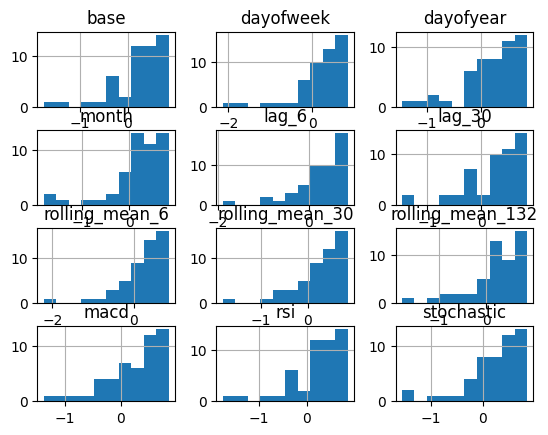

In [ ]:
results.hist()

In [ ]:
results.to_csv('metrics.csv')

In [ ]:
results.to_csv('/content/drive/MyDrive/metrics.csv')

#Linear Regression

In [ ]:
data_h4['months'] = [x.month for x in data_h4.index]
data_h4['day'] = [x.dayofweek for x in data_h4.index]

In [ ]:
data_h4 = data_h4.dropna()

In [ ]:
traindata = data_h4.dropna()

In [ ]:
traindata.tail(50)

,open,high,low,close,volume,spread,close_d,months,day,target
datetime,,,,,,,,,,
2023-08-01 08:00:00,1.09898,1.10003,1.09702,1.09744,12599,6.0,-0.00159,8,1,1.09805
2023-08-01 12:00:00,1.09745,1.09846,1.09525,1.09564,14178,0.0,-0.00180,8,1,1.09879
2023-08-03 16:00:00,1.09381,1.09628,1.09156,1.09553,26072,5.0,0.00172,8,3,1.09850
2023-08-03 20:00:00,1.09553,1.09570,1.09385,1.09480,4940,17.0,-0.00073,8,3,1.09995
2023-08-04 00:00:00,1.09490,1.09555,1.09293,1.09554,2803,135.0,0.00074,8,4,1.09683
2023-08-04 04:00:00,1.09554,1.09616,1.09493,1.09500,4974,7.0,-0.00054,8,4,1.09466
2023-08-04 08:00:00,1.09501,1.09584,1.09379,1.09404,9208,5.0,-0.00096,8,4,1.09451
2023-08-04 12:00:00,1.09404,1.09980,1.09349,1.09898,22191,6.0,0.00494,8,4,1.09356
2023-08-04 16:00:00,1.09894,1.10421,1.09859,1.10340,30949,0.0,0.00442,8,4,1.09463


In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(traindata[:-20].drop('target', axis=1).reset_index(drop=True), traindata['target'][:-20].reset_index(drop=True))

LinearRegression()

In [ ]:
predict = lr.predict(traindata[-20:].drop('target', axis=1).reset_index(drop=True))

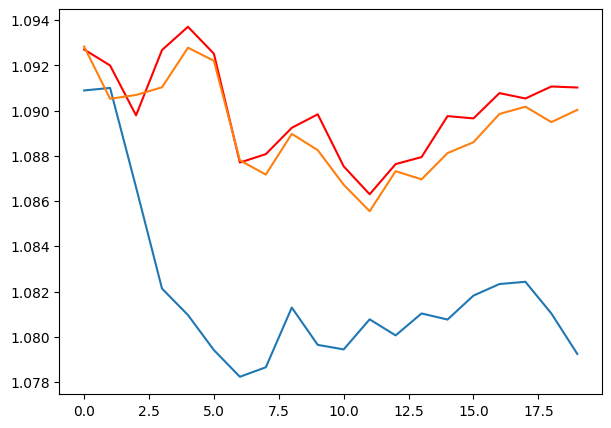

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(predict, color='r')
ax.plot(traindata[['target', 'close']][-20:].reset_index(drop=True))
plt.show()

#Trash

In [1]:
fplt.plot(
            data_h4.tail(30),
            type='candle',
            title='EURUSD',
            ylabel='Price',
            volume=True
        )

NameError: ignored

In [ ]:
_ = plot_pacf(data_h4['close'].dropna())

In [ ]:
_ = plot_acf(data_h4['close'].dropna())